## Graph Class docummentation <a class="anchor" id="class"></a>

My goal was to implement undirected graph structure in Python. The structure  

Class **Graph** has the following attributes:

- **vertices** -  A dictionary of vertices and their neighbors. Every vertex is represented by a key in the dictionary and it's value is a list of tuples. Every tuple stores two values, first value represents the neighbor and the second represents the weight of this bond.

For example the graph connection between '*Bob*' and '*Alice*' with bond weight = 0.5 can be represented by:

In [1]:
example_dictionary = {'Bob': [('Alice', 0.5)], 'Alice': [('Bob', 0.5)]}

Class **Graph** has the following methods:

- **__init__(self)** - initialization of graph dictionary.

- **addVertex(self, vert)** - adds vertice to existing graph. Method does not create duplicates.

- **addVerticesFromList(self, vertList)** - adds list of vertices to existing graph.

- **addEdge(self, fromVert, toVert, weight = 1)** - adds edge between two vertices **fromVert** and **toVert** with default **weight = 1**. If given vertices are not present in graph, the method creates them.

- **getVertices()** - Returns a list of all vertices in the graph.

- **getEdges()** - Returns a list of all edges in the graph.

- **getNeighbors(vertKey)** - Returns a list of neighbors of the given vertex **vertKey**. If the vertex does not exist, returns an empty list.

- **__contains__(vert)** - Returns **True** if the given vertex is in the graph, **False** otherwise.

- **saveGraph(filename)** - Saves the graph in the **DOT** language to a file. The file can be used with graph visualization software.

- **shortestDistance(fromVert)** - Returns dictionary with shortest distance between **fromVert** and other vertices in the graph. This method uses Dijkstra's algorithm to find the shortest path from the given vertex to all other vertices in the graph. 

## New methods (!) :

- **toNetworkx(self)** - converts the graph to a NetworkX object.

- **randomGraph(self, n, p)** - generates a random graph with n vertices and probability p of any two vertices being connected by an edge.

- **removeEdge(self, fromVert, toVert)** - removes the edge between two vertices.

- **wattsStrogatz1(self, n, k, p)** - generates a Watts-Strogatz small-world graph with n vertices, each vertex having k nearest neighbors and probability p of rewiring each edge.

## Class Implementation <a class="anchor" id="class-imp"></a>

In [3]:
import random
import networkx as nx

class Graph:
    
    def __init__(self):
        self.vertices = {}
        
    def addVertex(self, vert):
        if vert not in self.vertices:
            self.vertices[vert] = []
            
    def addVerticesFromList(self, vertList):
        for i in vertList:
            self.addVertex(i)
            
    def addEdge(self, fromVert, toVert, weight = 1):
        
        verts_args = (fromVert, toVert)
        
        for element in verts_args:
            if element not in self.vertices:
                self.addVertex(element)
    
        tup_toVert = (toVert, weight)
        tup_fromVert = (fromVert, weight)
        
        self.vertices[fromVert].append(tup_toVert)
        self.vertices[toVert].append(tup_fromVert)
        
    def getVertices(self):
        return self.vertices.keys()

    def getEdges(self):
        
        edges = []

        for vert in self.vertices:
            for neighbor, weight in self.vertices[vert]:
                if (neighbor, vert, weight) not in edges:
                    edges.append((vert, neighbor, weight))

        return edges
    
    def getNeighbors(self, vertKey):
        if vertKey in self.vertices:
            l = [neigh[0] for neigh in self.vertices[vertKey]]
        else:
            l = []
            
        #delete duplicates
        res = [*set(l)]
        return res
        
    
    def __contains__(self, vert):
        return vert in self.vertices
            
    def saveGraph(self, filename, add_label=False):
        with open(filename, 'w') as f:
            f.write('graph {\n')
            visited = set()
            for vert in self.vertices:
                for neigh, weight in self.vertices[vert]:
                    if (vert, neigh) not in visited and (neigh, vert) not in visited:
                        if add_label:
                            f.write('\t{} -- {} [label={}];\n'.format(vert, neigh, weight))
                        else:
                            f.write('\t{} -- {};\n'.format(vert, neigh))
                        visited.add((vert, neigh))
            f.write('}\n')

    def getShortestPaths(self, fromVert):
        distances = {vert: float('inf') for vert in self.vertices}
        distances[fromVert] = 0
        visited = {vert: False for vert in self.vertices}

        while True:
            minDist = float('inf')
            minVert = None
            for vert in self.vertices:
                if not visited[vert] and distances[vert] < minDist:
                    minDist = distances[vert]
                    minVert = vert

            if minVert is None:
                break

            for neigh, weight in self.vertices[minVert]:
                newDist = distances[minVert] + weight
                if newDist < distances[neigh]:
                    distances[neigh] = newDist

            visited[minVert] = True

        return distances
    
    def toNetworkx(self):
        nx_graph = nx.Graph()

        for vertex in self.vertices:
            nx_graph.add_node(vertex)

        for edge in self.getEdges():
            from_vert, to_vert, weight = edge
            nx_graph.add_edge(from_vert, to_vert, weight=weight)

        return nx_graph

    def randomGraph(self, n, p):
        self.vertices = {}
        self.numVertices = 0

        for node in range(n):
            self.addVertex(node)

        edges = [(i, j) for i in range(n) for j in range(i + 1, n) if random.random() < p]

        for i, j in edges:
            self.addEdge(i, j)

        return self
                    
    def removeEdge(self, fromVert, toVert):
        if fromVert in self.vertices and toVert in self.vertices:
            self.vertices[fromVert] = [(v, w) for v, w in self.vertices[fromVert] if v != toVert]
            self.vertices[toVert] = [(v, w) for v, w in self.vertices[toVert] if v != fromVert]
            
    def regularLattice(self, n, k):
        # Step 1: Create a ring of nodes with each node connected to its k nearest neighbors
        for i in range(n):
            for j in range(1, k // 2 + 1):
                self.addEdge(i, (i + j) % n)
                self.addEdge(i, (i - j) % n)
        return self
    
    def rewire(self, vertex, new_edge):
        edges = self.vertices[vertex]
        self.vertices[vertex] = [(new_edge, weight) for _, weight in edges]
        self.addEdge(vertex, new_edge)
        for neighbor in self.vertices:
            neighbor_edges = self.vertices[neighbor]
            self.vertices[neighbor] = [(vertex, weight) if neighbor == v else (v, weight) for v, weight in neighbor_edges]
        return self
    
    def wattStrogatz(self, n, k, p):
        self.regularLattice(n, k)
        nodes = list(self.vertices.keys())
        for node in nodes:
            neighbors = [neighbor[0] for neighbor in self.vertices[node]]
            for neighbor in neighbors:
                if node < neighbor and node+k//2 >= neighbor:
                    if random.random() < p:
                        self.removeEdge(node, neighbor)
                        possible_nodes = [n for n in nodes if n != node and n not in neighbors]
                        new_neighbor = random.choice(possible_nodes)
                        self.addEdge(node, new_neighbor)
        return self
    
    def barabasiAlbert(self, n, m):
        # Add m initial vertices
        for i in range(m):
            self.addVertex(i)
        # Create a list with m copies of the initial vertices
        targets = [j for j in self.vertices for i in range(len(self.vertices[j]))][:m]
        # Repeat until the graph has n vertices
        while len(self.vertices) < n:
            # Add a new vertex
            self.addVertex(len(self.vertices))
            # Add m edges that link the new vertex to m distinct vertices in the graph
            for i in range(m):
                if len(targets) == 0:
                    break
                # Choose a target vertex uniformly at random from the list of targets
                target = random.choice(targets)
                # Add an edge from the new vertex to the target vertex
                self.addEdge(len(self.vertices) - 1, target)
                # Remove the target vertex from the list of targets if it has m neighbors already
                if len(self.vertices[target]) == m:
                    targets.remove(target)
            # Add m copies of the new vertex to the list of targets
            targets.extend([len(self.vertices) - 1] * m)
            
        # Connect any remaining isolated vertices to a random connected vertex
        isolated = [vert for vert in self.vertices if not self.vertices[vert]]
        while isolated:
            v = isolated.pop()
            u = random.choice(list(self.vertices.keys()))
            self.addEdge(u, v)

### What's new? <a class="anchor" id="ex1"></a>

Demo of new methods **randomGraph** and **toNetworkx**. Simple implementation of a random graph with 50 vertices and probability $p = 0.02$ of connection.

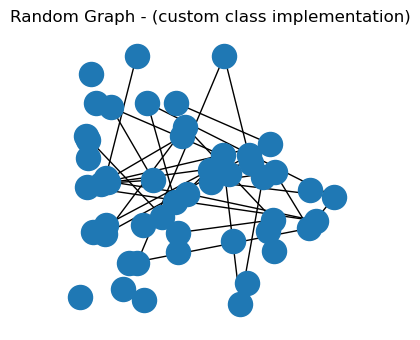

In [4]:
import matplotlib.pyplot as plt

graph = Graph()
graph.randomGraph(50, 0.02)

x = graph.toNetworkx()

plt.figure(figsize=(3, 3))
nx.draw(x, pos=nx.random_layout(x))
plt.title('Random Graph - (custom class implementation)')
plt.show()

## Regular Lattice

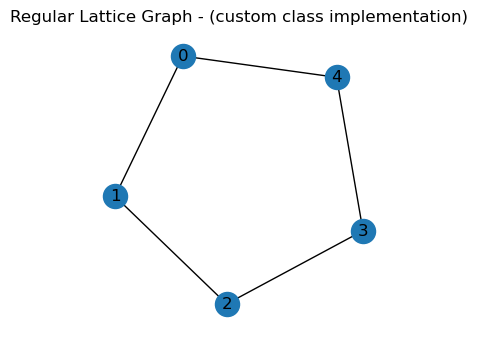

[(0, 1, 1), (0, 4, 1), (0, 1, 1), (0, 4, 1), (1, 2, 1), (1, 2, 1), (4, 3, 1), (4, 3, 1), (2, 3, 1), (2, 3, 1)]


In [5]:
regular = Graph()
regular.regularLattice(5, 2)
regular_nx = regular.toNetworkx()

plt.figure(figsize=(3, 3))
nx.draw(regular_nx, with_labels = True)
plt.title('Regular Lattice Graph - (custom class implementation)')
plt.show()

print(regular.getEdges())

TypeError: 'Graph' object is not iterable

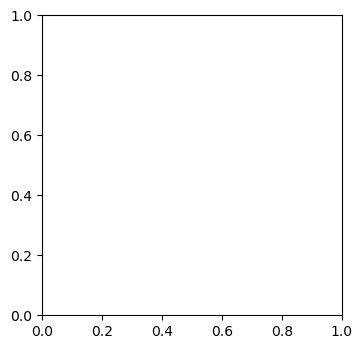

In [10]:
#Graph class method
ws = Graph()
ws.wattStrogatz(10, 2, 0)

plt.figure(figsize=(3, 3))
nx.draw(ws)
plt.title('Watt-Strogatz graph - (custom class implementation)')
plt.show()

#networkX impkementation for reference
ws_nx = nx.watts_strogatz_graph(10, 2, 0)

plt.figure(figsize=(3, 3))
nx.draw(ws_nx)
plt.title('Watt-Strogatz graph - (NetworkX reference)')
plt.show()

In [ ]:
n = 200
m = 1

ba = Graph()
ba.barabasiAlbert(n, m)
ba_converted = ba.toNetworkx()

plt.figure(figsize=(3, 3))
nx.draw(ba_converted, node_size = 5)
plt.title('Barabasi-Alberts graph - (custom class implementation)')
plt.show()

ba_nx = nx.barabasi_albert_graph(n, m)

plt.figure(figsize=(3, 3))
nx.draw(ba_nx, node_size = 5)
plt.title('Barabasi-Alberts graph - (NetworkX reference)')
plt.show()

## Exercise 1a)

Set the number of nodes to N = 2000, simulate the models for various
settings of the parameters and save the graphs. You may use graph data
structures provided by the existing network libraries or your own class to
store the graphs. For each graph:

- Report the number of vertices and edges.
- Compute the average degree and the variance of the degree distribution.
- Generate the frequency plot for the degrees of the nodes.
- Fit a model distribution to the obtained data. In case of the Barabasi-Albert graph, you may have a look at https://aaronclauset.github.io/powerlaws/data.htm


In [ ]:
import numpy as np
import scipy.stats 

#function based on example from networkX doccumnetation 
#https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
def graph_distribution_info(G, name):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    davg = np.mean(degree_sequence)
    dvar = np.var(degree_sequence)
    
    print(f'Max Degree of a {name} = {dmax}')
    print(f'Average Degree of a {name} = {davg}')
    print(f'Variance of a Degree destribution = {dvar}')
    
    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=33)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
    ax0.set_title(f"Connected components of {name}")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

In [ ]:
#intialization of graphs
rand_graph = Graph()
ws_graph = Graph()
ba_graph = Graph()

In [ ]:
#paramters initialization
N = 2000
p_random = 0.001

rand_graph.randomGraph(N, p_random)
G = rand_graph.toNetworkx()

In [ ]:
graph_distribution_info(G, 'random_graph')

In [ ]:
ba1 = nx.barabasi_albert_graph(300, 20)

ba2 = Graph()
ba2.barabasiAlbert(300, 20)
ba2 = ba2.toNetworkx()


graph_distribution_info(ba1, 'ba')
graph_distribution_info(ba2, 'ba')